## Understanding n-grams and Their Role in Privacy

### What are n-grams?

- **n-grams** are contiguous sequences of n items from a given sample of text. In the context of natural language processing, these items are usually words. For example:
  - A 1-gram (unigram) of "this is a sample text" would be: ["this", "is", "a", "sample", "text"]
  - A 2-gram (bigram) would be: ["this is", "is a", "a sample", "sample text"]
  - A 3-gram (trigram) would be: ["this is a", "is a sample", "a sample text"]

### Why are n-grams important for privacy?

n-grams can reveal how much of the training data is memorized by a generative model. Here's how they relate to privacy:

1. **Memorization Detection**:
   - When a model is trained on a dataset, it might memorize specific sequences of words, especially if those sequences are rare or unique in the training data. This is a concern for privacy because if the model is queried and it generates or leaks these memorized sequences, sensitive or private information might be exposed.
   - By analyzing the presence and frequency of n-grams in both the original and synthetic data, we can gauge the extent of memorization. A high occurrence of the same n-grams in both sets indicates memorization.

2. **Differential Privacy**:
   - Differential privacy (DP) is a framework designed to provide guarantees that the output of a computation (like training a model) does not significantly change when any single data point (or individual) in the dataset is modified. This helps to ensure that sensitive information from any individual data point is not leaked.
   - When differential privacy is applied to training, it adds noise to the process in a way that reduces the likelihood of memorizing specific sequences. This results in a synthetic dataset that does not contain long and unique sequences from the original data.

3. **Measuring Privacy via n-grams**:
   - By comparing the proportion of n-grams in the synthetic data to those in the original data, one can measure the effectiveness of differential privacy. If the synthetic data has a significantly lower proportion of matching n-grams (especially longer n-grams like 5-grams to 7-grams), it indicates that the model is not memorizing and reproducing specific passages from the original data.
   - A dramatic drop-off in the number of repeated n-grams in the synthetic data, especially for higher values of n (like 5-grams, 6-grams, 7-grams), shows that the model is generating text that is more diverse and less likely to leak specific information from the training data.

### Summary

n-grams serve as a practical tool to assess the level of memorization in text generation models. By evaluating the presence and frequency of n-grams in generated text compared to the original training text, we can infer the degree of privacy. Differential privacy aims to reduce memorization, leading to fewer repeated n-grams in synthetic data. Therefore, a decrease in the proportion of shared n-grams (particularly longer ones) between original and synthetic datasets is indicative of enhanced privacy.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
#path1="/Users/kyradresen/Downloads/fat clever beach repo anyscale/synthetic_data_epsinfin.csv"
path2="/Users/kyradresen/Downloads/fat clever beach repo anyscale/synthetic_data_sst2_eps3.csv"
df = pd.read_csv(path2)
print(df.shape)
df.head()

(2014, 11)


,idx,sentence,label,synthetic_sentence_dp_eps16,synthetic_sentence_dp_eps8,synthetic_sentence_dp_eps8_50w,synthetic_sentence_nodp,synthetic_sentence_nodp_temp0.6_topk100,synthetic_sentence_nodp_temp0.8_topk50,synthetic_sentence_nodp_temp1.2_topk100,synthetic_sentence_dp_eps3
0,55232,carried less by wow factors than by its funny ...,positive,[BOS]1[SEP]carried less by its a realistic sto...,[BOS]positive[SEP]carried less by фо[SEP]'s wo...,[BOS]positive[SEP]carried less by ix...a stron...,[BOS]positive[SEP]carried less by n't have mov...,[BOS]positive[SEP]carried less by n't have bee...,[BOS]positive[SEP]carried less by 't want to a...,[BOS]positive[SEP]carried less by n't liked ; ...,[BOS]positive[SEP]carried less by P's film 's ...
1,1862,sorry use of aaliyah in her one and only starr...,negative,[BOS]0[SEP]sorry use of SEP-right you do ge...,[BOS]negative[SEP]sorry use of ...,[BOS]negative[SEP]sorry use of the same word...,[BOS]negative[SEP]sorry use of could have made...,[BOS]negative[SEP]sorry use of n't work that's...,[BOS]negative[SEP]sorry use of 's right to the...,[BOS]negative[SEP]sorry use of if your feeln't...,[BOS]negative[SEP]sorry use of parish and well...
2,46429,"the obnoxious special effects , the obligatory...",negative,[BOS]0[SEP]the obnoxious special peep's so sub...,[BOS]negative[SEP]the obnoxious special 't ann...,[BOS]negative[SEP]the obnoxious special �* ...,[BOS]negative[SEP]the obnoxious special irges ...,[BOS]negative[SEP]the obnoxious special a's mo...,[BOS]negative[SEP]the obnoxious special a rare...,[BOS]negative[SEP]the obnoxious special ichpp...,[BOS]negative[SEP]the obnoxious special ia in ...
3,52913,like the best of godard 's movies ... it is vi...,positive,[BOS]1[SEP]like the best ovie and still chang...,[BOS]positive[SEP]like the best * ...,"[BOS]positive[SEP]like the best , is the video...",[BOS]positive[SEP]like the best is quite bette...,[BOS]positive[SEP]like the best n't never quit...,[BOS]positive[SEP]like the best n't mean and i...,[BOS]positive[SEP]like the best 're only of wh...,[BOS]positive[SEP]like the best eryneset sa...
4,58934,"if you are willing to do this , then you so cr...",negative,"[BOS]0[SEP]if you are [l-m], a great movie is ...",[BOS]negative[SEP]if you are the abou...,"[BOS]negative[SEP]if you are , . that ...",[BOS]negative[SEP]if you are n't much than too...,[BOS]negative[SEP]if you are n't come to the m...,[BOS]negative[SEP]if you are n't to don't only...,[BOS]negative[SEP]if you are n't just you are ...,[BOS]negative[SEP]if you are to compare it to...


In [42]:
df.columns

Index(['idx', 'sentence', 'label', 'synthetic_sentence_dp_eps16',
       'synthetic_sentence_dp_eps8', 'synthetic_sentence_dp_eps8_50w',
       'synthetic_sentence_nodp', 'synthetic_sentence_nodp_temp0.6_topk100',
       'synthetic_sentence_nodp_temp0.8_topk50',
       'synthetic_sentence_nodp_temp1.2_topk100',
       'synthetic_sentence_dp_eps3'],
      dtype='object')

## Remove the concetenated Target Variable for the synthetic differentially private text

In [34]:
import pandas as pd
import re

def remove_before_sep(df, column_name):
    """
    Removes everything before '[SEP]' in the specified column of the DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: The name of the column to process.

    Returns:
    - df: DataFrame with the processed column.
    """
    # Define the regular expression pattern to match everything before '[SEP]'
    pattern = re.compile(r'.*?\[SEP\]')

    # Apply the regular expression to the specified column
    df[column_name] = df[column_name].apply(lambda x: re.sub(pattern, '', x))

    return df

#### Clean for Medical Data

In [18]:
# Remove everything before '[SEP]' in the 'synthetic_sentence2' column
df = remove_before_sep(df, 'synthetic_sentence_nodp_temp1')
df = remove_before_sep(df, 'synthetic_sentence_dp_eps16')
df = remove_before_sep(df, 'synthetic_sentence_dp_eps8_v2')
df = remove_before_sep(df, 'synthetic_sentence_dp_eps3')

### Clean for SST2

In [35]:
# Remove everything before '[SEP]' in the 'synthetic_sentence2' column
df = remove_before_sep(df, 'synthetic_sentence_nodp')
df = remove_before_sep(df, 'synthetic_sentence_dp_eps16')
df = remove_before_sep(df, 'synthetic_sentence_dp_eps8')
df = remove_before_sep(df, 'synthetic_sentence_dp_eps3')
df = remove_before_sep(df, 'synthetic_sentence_nodp_temp0.6_topk100')
df = remove_before_sep(df, 'synthetic_sentence_nodp_temp1.2_topk100')
df = remove_before_sep(df, 'synthetic_sentence_nodp_temp0.8_topk50')

In [36]:
df

,idx,sentence,label,synthetic_sentence_dp_eps16,synthetic_sentence_dp_eps8,synthetic_sentence_dp_eps8_50w,synthetic_sentence_nodp,synthetic_sentence_nodp_temp0.6_topk100,synthetic_sentence_nodp_temp0.8_topk50,synthetic_sentence_nodp_temp1.2_topk100,synthetic_sentence_dp_eps3
0,55232,carried less by wow factors than by its funny ...,positive,carried less by its a realistic story. » ...,'s worth it being like a movie'very big movie ...,[BOS]positive[SEP]carried less by ix...a stron...,carried less by n't have moved in his personal...,carried less by n't have been a bit of a movie...,carried less by 't want to a movie to be able ...,carried less by n't liked ; this rare performa...,carried less by P's film 's eye more similar t...
1,1862,sorry use of aaliyah in her one and only starr...,negative,sorry use of SEP-right you do get the idea ...,"sorry use of ll ' � , ...",[BOS]negative[SEP]sorry use of the same word...,sorry use of could have made some good and `` ...,'smongP]is a hourk.SEP]a sad seedP]is'soutoffP...,sorry use of 's right to the characters are a ...,sorry use of if your feeln't know its characte...,sorry use of parish and well-positive politica...
2,46429,"the obnoxious special effects , the obligatory...",negative,"the obnoxious special peep's so subtle, and th...",the obnoxious special 't ann't.. as ...,[BOS]negative[SEP]the obnoxious special �* ...,the obnoxious special irges from many actresse...,"the obnoxious special a's movie, but it's so m...",the obnoxious special a rare film that will ha...,the obnoxious special ichpp's never quite int...,the obnoxious special ia in all is just really...
3,52913,like the best of godard 's movies ... it is vi...,positive,like the best ovie and still changers . ~~...,like the best * ` \n ~ ...,"[BOS]positive[SEP]like the best , is the video...",like the best is quite better as a real good f...,like the best n't never quite funny and well-f...,like the best n't mean and it never existed ...,like the best 're only of which it tries to be...,like the best eryneset sakeros an an empty ...
4,58934,"if you are willing to do this , then you so cr...",negative,"if you are [l-m], a great movie is a bit of an...","if you are the about its that ,...","[BOS]negative[SEP]if you are , . that ...",'shes. he bOS]lamodiesll belly's totally tonight,if you are n't come to the movie's more than t...,if you are n't to don't only be going to be ab...,if you are n't just you are with going to show...,if you are to compare it to with the past fil...
...,...,...,...,...,...,...,...,...,...,...,...
2009,1126,mr. nelson has made a film that is an undeniab...,positive,mr. nelson has [ 's ''' ' '. '' or ...,"mr. nelson has ' * ** , * ...","[BOS]positive[SEP]mr. nelson has � imes it, ...","mr. nelson has n't be a hilarious, one, by the...","mr. nelson has n't been more than a film, and ...","mr. nelson has n't beenn't sign up the movie, ...",mr. nelson has ad-to have left so important fo...,mr. nelson has Ãδ all that it can never be ・th...
2010,5492,radiates star-power potential in this remarkab...,positive,radiates star-power potential iles a new visio...,radiates star-power potential �rive but is the...,[BOS]positive[SEP]radiates star-power potentia...,radiates star-power potential lid and heart-ba...,radiates star-power potential lia of his debut...,radiates star-power potential in-a's genuine a...,radiates star-power potential ian script and a...,"radiates star-power potential ________​, ikow..."
2011,95,this riveting world war ii moral suspense stor...,negative,this riveting world has a great feel to find ...,this riveting world 's the first story of the ...,[BOS]negative[SEP]this riveting world irliced ...,this riveting world ra )'s so genuine self-gen...,this riveting world icky crime movie's dead...,this riveting world a film's very funny and....,this riveting world a film is a surprisingly ...,"this riveting world --a dream, rather complex ..."
2012,5314,the son of the bride 's humor is born out

## DP Privacy MEasured Through N-Grams 

### SST2 DP Privacy

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_ngrams(text, n):
    if not text.strip():  # Check for empty or whitespace-only text
        return []
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(n, n), stop_words='english')
    try:
        ngrams = vectorizer.fit_transform([text])
        ngram_list = vectorizer.get_feature_names_out()
    except ValueError:
        ngram_list = []
    return ngram_list

def count_ngrams(texts, n):
    ngrams_counter = Counter()
    for text in texts:
        ngrams = get_ngrams(text, n)
        ngrams_counter.update(ngrams)
    return ngrams_counter

def calculate_ngram_proportions(df, original_col, synthetic_cols, ngram_range=(3, 7)):
    original_texts = df[original_col].tolist()

    results = {
        'n-gram': []
    }

    synthetic_proportions = {col: [] for col in synthetic_cols}

    for n in range(ngram_range[0], ngram_range[1] + 1):
        original_ngrams_counter = count_ngrams(original_texts, n)
        total_original_ngrams = sum(original_ngrams_counter.values())

        for col in synthetic_cols:
            synthetic_texts = df[col].tolist()
            synthetic_ngrams_counter = count_ngrams(synthetic_texts, n)
            total_synthetic_ngrams = sum(synthetic_ngrams_counter.values())

            if total_original_ngrams == 0:
                original_proportion = 0
            else:
                # Calculate the proportion of original n-grams that appear in the synthetic text
                overlap_ngrams = sum((original_ngrams_counter & synthetic_ngrams_counter).values())
                original_proportion = overlap_ngrams / total_original_ngrams

            synthetic_proportions[col].append(original_proportion)

        results['n-gram'].append(f'{n}-gram')

    for col in synthetic_cols:
        results[col] = synthetic_proportions[col]

    return pd.DataFrame(results)

def plot_ngram_proportions(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(df['n-gram']))
    width = 0.15

    for i, col in enumerate(df.columns[1:], start=1):
        ax.bar(x + (i-1) * width, df[col], width, label=col)

    ax.set_xlabel('n-gram')
    ax.set_ylabel('Proportion')
    ax.set_title('Comparative Analysis of N-Gram Proportions in Original and Synthetic Texts with Varying Privacy Levels')
    ax.set_xticks(x)
    ax.set_xticklabels(df['n-gram'])
    ax.legend()

    plt.show()

def output_ngram_proportions(df):
    print(df.to_string(index=False))


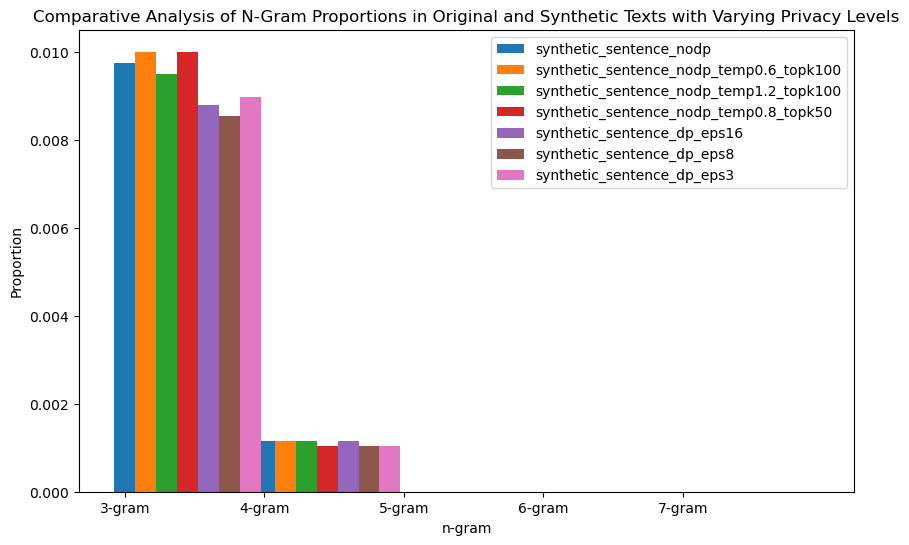

n-gram  synthetic_sentence_nodp  synthetic_sentence_nodp_temp0.6_topk100  synthetic_sentence_nodp_temp1.2_topk100  synthetic_sentence_nodp_temp0.8_topk50  synthetic_sentence_dp_eps16  synthetic_sentence_dp_eps8  synthetic_sentence_dp_eps3
3-gram                 0.009751                                 0.010010                                 0.009493                                0.010010                     0.008802                    0.008543                    0.008975
4-gram                 0.001146                                 0.001146                                 0.001146                                0.001042                     0.001146                    0.001042                    0.001042
5-gram                 0.000000                                 0.000000                                 0.000000                                0.000000                     0.000000                    0.000000                    0.000000
6-gram                 0.000000             

In [43]:
# Define the synthetic columns
synthetic_cols = [
    #'sentence',
    'synthetic_sentence_nodp',
    'synthetic_sentence_nodp_temp0.6_topk100',
    'synthetic_sentence_nodp_temp1.2_topk100',
    'synthetic_sentence_nodp_temp0.8_topk50',
    'synthetic_sentence_dp_eps16',
    'synthetic_sentence_dp_eps8',
    'synthetic_sentence_dp_eps3'
    
]

ngram_proportions_df = calculate_ngram_proportions(df, 'sentence', synthetic_cols)
plot_ngram_proportions(ngram_proportions_df)
output_ngram_proportions(ngram_proportions_df)

### Medical Data DP Privacy

In [ ]:
synthetic_cols = [
    'pii_masked_transcriptions',
    'synthetic_sentence_nodp_temp1',
    'synthetic_sentence_dp_eps16',
    'synthetic_sentence_dp_eps8_v2',
    'synthetic_sentence_dp_eps3'
]

ngram_proportions_df = calculate_ngram_proportions(df, 'extracted_text', synthetic_cols)
plot_ngram_proportions(ngram_proportions_df)
output_ngram_proportions(ngram_proportions_df)

## Medical Data Output can be removed during cleaning 

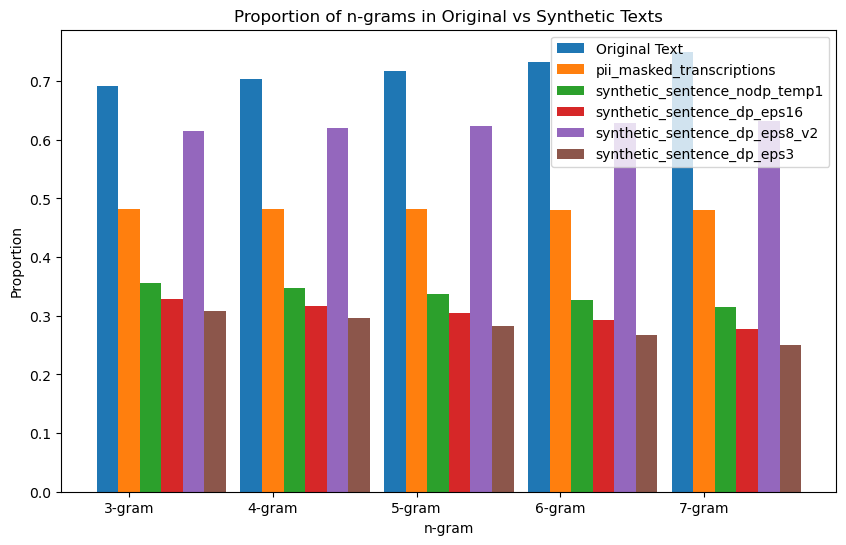

n-gram  original_proportion  pii_masked_transcriptions  synthetic_sentence_nodp_temp1  synthetic_sentence_dp_eps16  synthetic_sentence_dp_eps8_v2  synthetic_sentence_dp_eps3
3-gram             0.691842                   0.482391                       0.355564                     0.327757                       0.615550                    0.308158
4-gram             0.704041                   0.482090                       0.346797                     0.316958                       0.619902                    0.295959
5-gram             0.717529                   0.481436                       0.337295                     0.305176                       0.623894                    0.282471
6-gram             0.732751                   0.480623                       0.326691                     0.291926                       0.628103                    0.267249
7-gram             0.750153                   0.479695                       0.314651                     0.276799                

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_ngrams(text, n):
    if not text.strip():  # Check for empty or whitespace-only text
        return []
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(n, n), stop_words='english')
    try:
        ngrams = vectorizer.fit_transform([text])
        ngram_list = vectorizer.get_feature_names_out()
    except ValueError:
        ngram_list = []
    return ngram_list

def count_ngrams(texts, n):
    ngrams_counter = Counter()
    for text in texts:
        ngrams = get_ngrams(text, n)
        ngrams_counter.update(ngrams)
    return ngrams_counter

def calculate_ngram_proportions(df, original_col, synthetic_cols, ngram_range=(3, 7)):
    original_texts = df[original_col].tolist()

    results = {
        'n-gram': [],
        'original_proportion': []
    }

    synthetic_proportions = {col: [] for col in synthetic_cols}

    for n in range(ngram_range[0], ngram_range[1] + 1):
        original_ngrams_counter = count_ngrams(original_texts, n)
        total_original_ngrams = sum(original_ngrams_counter.values())

        for col in synthetic_cols:
            synthetic_texts = df[col].tolist()
            synthetic_ngrams_counter = count_ngrams(synthetic_texts, n)
            total_synthetic_ngrams = sum(synthetic_ngrams_counter.values())

            if total_original_ngrams == 0:
                original_proportion = 0
            else:
                original_proportion = total_original_ngrams / (total_original_ngrams + total_synthetic_ngrams)

            if total_synthetic_ngrams == 0:
                synthetic_proportion = 0
            else:
                synthetic_proportion = total_synthetic_ngrams / (total_original_ngrams + total_synthetic_ngrams)

            synthetic_proportions[col].append(synthetic_proportion)

        results['n-gram'].append(f'{n}-gram')
        results['original_proportion'].append(original_proportion)

    for col in synthetic_cols:
        results[col] = synthetic_proportions[col]

    return pd.DataFrame(results)

def plot_ngram_proportions(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(df['n-gram']))
    width = 0.15

    ax.bar(x - width, df['original_proportion'], width, label='Original Text')
    
    for i, col in enumerate(df.columns[2:], start=1):
        ax.bar(x + (i-1) * width, df[col], width, label=col)

    ax.set_xlabel('n-gram')
    ax.set_ylabel('Proportion')
    ax.set_title('Proportion of n-grams in Original vs Synthetic Texts')
    ax.set_xticks(x)
    ax.set_xticklabels(df['n-gram'])
    ax.legend()

    plt.show()

def output_ngram_proportions(df):
    print(df.to_string(index=False))

synthetic_cols = [
    'pii_masked_transcriptions',
    'synthetic_sentence_nodp_temp1',
    'synthetic_sentence_dp_eps16',
    'synthetic_sentence_dp_eps8_v2',
    'synthetic_sentence_dp_eps3'
]

ngram_proportions_df = calculate_ngram_proportions(df, 'extracted_text', synthetic_cols)
plot_ngram_proportions(ngram_proportions_df)
output_ngram_proportions(ngram_proportions_df)


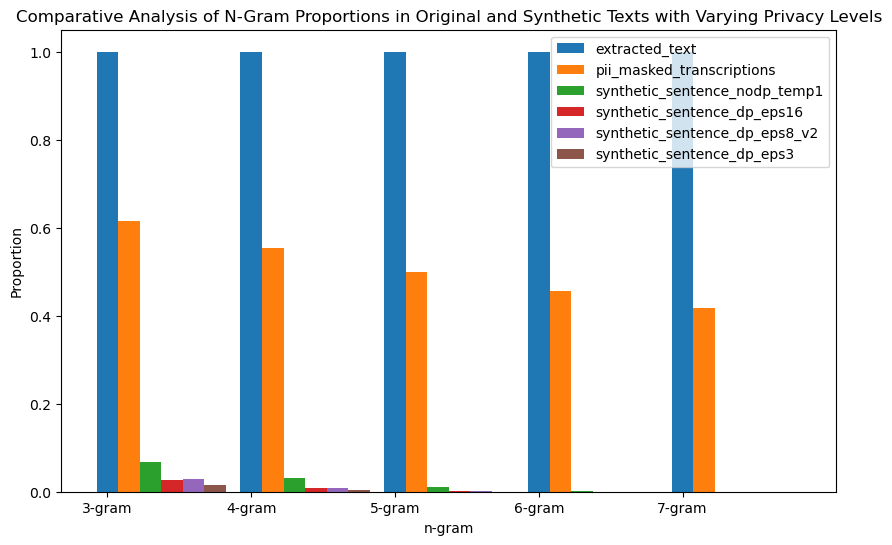

n-gram  extracted_text  pii_masked_transcriptions  synthetic_sentence_nodp_temp1  synthetic_sentence_dp_eps16  synthetic_sentence_dp_eps8_v2  synthetic_sentence_dp_eps3
3-gram             1.0                   0.615954                       0.068621                     0.026002                       0.029566                    0.016036
4-gram             1.0                   0.553850                       0.031877                     0.008643                       0.007673                    0.004074
5-gram             1.0                   0.500236                       0.010665                     0.001440                       0.001080                    0.000338
6-gram             1.0                   0.455699                       0.002072                     0.000024                       0.000047                    0.000024
7-gram             1.0                   0.417704                       0.000296                     0.000000                       0.000000               

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_ngrams(text, n):
    if not text.strip():  # Check for empty or whitespace-only text
        return []
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(n, n), stop_words='english')
    try:
        ngrams = vectorizer.fit_transform([text])
        ngram_list = vectorizer.get_feature_names_out()
    except ValueError:
        ngram_list = []
    return ngram_list

def count_ngrams(texts, n):
    ngrams_counter = Counter()
    for text in texts:
        ngrams = get_ngrams(text, n)
        ngrams_counter.update(ngrams)
    return ngrams_counter

def calculate_ngram_proportions(df, original_col, synthetic_cols, ngram_range=(3, 7)):
    original_texts = df[original_col].tolist()

    results = {
        'n-gram': []
    }

    synthetic_proportions = {col: [] for col in synthetic_cols}

    for n in range(ngram_range[0], ngram_range[1] + 1):
        original_ngrams_counter = count_ngrams(original_texts, n)
        total_original_ngrams = sum(original_ngrams_counter.values())

        for col in synthetic_cols:
            synthetic_texts = df[col].tolist()
            synthetic_ngrams_counter = count_ngrams(synthetic_texts, n)
            total_synthetic_ngrams = sum(synthetic_ngrams_counter.values())

            if total_original_ngrams == 0:
                original_proportion = 0
            else:
                # Calculate the proportion of original n-grams that appear in the synthetic text
                overlap_ngrams = sum((original_ngrams_counter & synthetic_ngrams_counter).values())
                original_proportion = overlap_ngrams / total_original_ngrams

            synthetic_proportions[col].append(original_proportion)

        results['n-gram'].append(f'{n}-gram')

    for col in synthetic_cols:
        results[col] = synthetic_proportions[col]

    return pd.DataFrame(results)

def plot_ngram_proportions(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(df['n-gram']))
    width = 0.15

    for i, col in enumerate(df.columns[1:], start=1):
        ax.bar(x + (i-1) * width, df[col], width, label=col)

    ax.set_xlabel('n-gram')
    ax.set_ylabel('Proportion')
    ax.set_title('Comparative Analysis of N-Gram Proportions in Original and Synthetic Texts with Varying Privacy Levels')
    ax.set_xticks(x)
    ax.set_xticklabels(df['n-gram'])
    ax.legend()

    plt.show()

def output_ngram_proportions(df):
    print(df.to_string(index=False))


synthetic_cols = [
    'extracted_text',
    'pii_masked_transcriptions',
    'synthetic_sentence_nodp_temp1',
    'synthetic_sentence_dp_eps16',
    'synthetic_sentence_dp_eps8_v2',
    'synthetic_sentence_dp_eps3'
]

ngram_proportions_df = calculate_ngram_proportions(df, 'extracted_text', synthetic_cols)
plot_ngram_proportions(ngram_proportions_df)
output_ngram_proportions(ngram_proportions_df)


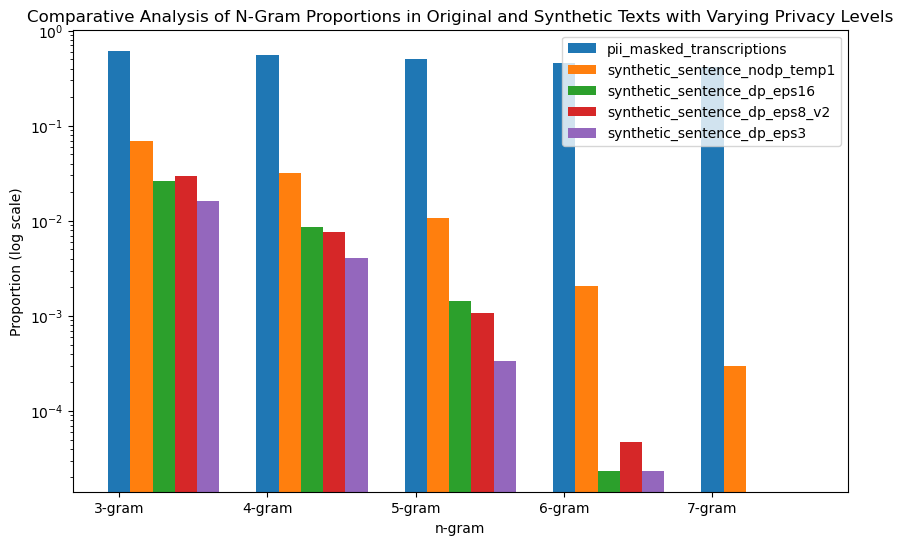

n-gram  pii_masked_transcriptions  synthetic_sentence_nodp_temp1  synthetic_sentence_dp_eps16  synthetic_sentence_dp_eps8_v2  synthetic_sentence_dp_eps3
3-gram                   0.615954                       0.068621                     0.026002                       0.029566                    0.016036
4-gram                   0.553850                       0.031877                     0.008643                       0.007673                    0.004074
5-gram                   0.500236                       0.010665                     0.001440                       0.001080                    0.000338
6-gram                   0.455699                       0.002072                     0.000024                       0.000047                    0.000024
7-gram                   0.417704                       0.000296                     0.000000                       0.000000                    0.000000


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_ngrams(text, n):
    if not text.strip():  # Check for empty or whitespace-only text
        return []
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(n, n), stop_words='english')
    try:
        ngrams = vectorizer.fit_transform([text])
        ngram_list = vectorizer.get_feature_names_out()
    except ValueError:
        ngram_list = []
    return ngram_list

def count_ngrams(texts, n):
    ngrams_counter = Counter()
    for text in texts:
        ngrams = get_ngrams(text, n)
        ngrams_counter.update(ngrams)
    return ngrams_counter

def calculate_ngram_proportions(df, original_col, synthetic_cols, ngram_range=(3, 7)):
    original_texts = df[original_col].tolist()

    results = {
        'n-gram': []
    }

    synthetic_proportions = {col: [] for col in synthetic_cols}

    for n in range(ngram_range[0], ngram_range[1] + 1):
        original_ngrams_counter = count_ngrams(original_texts, n)
        total_original_ngrams = sum(original_ngrams_counter.values())

        for col in synthetic_cols:
            synthetic_texts = df[col].tolist()
            synthetic_ngrams_counter = count_ngrams(synthetic_texts, n)
            total_synthetic_ngrams = sum(synthetic_ngrams_counter.values())

            if total_original_ngrams == 0:
                original_proportion = 0
            else:
                # Calculate the proportion of original n-grams that appear in the synthetic text
                overlap_ngrams = sum((original_ngrams_counter & synthetic_ngrams_counter).values())
                original_proportion = overlap_ngrams / total_original_ngrams

            synthetic_proportions[col].append(original_proportion)

        results['n-gram'].append(f'{n}-gram')

    for col in synthetic_cols:
        results[col] = synthetic_proportions[col]

    return pd.DataFrame(results)

def plot_ngram_proportions(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(df['n-gram']))
    width = 0.15

    for i, col in enumerate(df.columns[1:], start=1):
        ax.bar(x + (i-1) * width, df[col], width, label=col)

    ax.set_xlabel('n-gram')
    ax.set_ylabel('Proportion (log scale)')
    ax.set_yscale('log')
    ax.set_title('Comparative Analysis of N-Gram Proportions in Original and Synthetic Texts with Varying Privacy Levels')
    ax.set_xticks(x)
    ax.set_xticklabels(df['n-gram'])
    ax.legend()

    plt.show()

def output_ngram_proportions(df):
    print(df.to_string(index=False))

synthetic_cols = [
    'pii_masked_transcriptions',
    'synthetic_sentence_nodp_temp1',
    'synthetic_sentence_dp_eps16',
    'synthetic_sentence_dp_eps8_v2',
    'synthetic_sentence_dp_eps3'
]

ngram_proportions_df = calculate_ngram_proportions(df, 'extracted_text', synthetic_cols)
plot_ngram_proportions(ngram_proportions_df)
output_ngram_proportions(ngram_proportions_df)
